# Ridge(L2 Regularization) Regression

## References

- https://www.youtube.com/watch?v=Q81RR3yKn30 (statquest)

## Theory

- When sample sizes are relatively small then Ridge Regression can improve predictions made from new data (introducing bias and reducing variance) by making predictions less sensitive to training data.
- Even when there is no enough data to find least square solution, ridge regression can find a solution using cross validation and penalty.

## Generate Data

In [1]:
import pandas as pd 
import numpy as np
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d
import seaborn as sns

from matplotlib import animation
from IPython import display

from utility import regression_plot, regression_animation

In [2]:
def add_axis_for_bias(X_i):
    m, n = X_i.shape
    if False in (X_i[:,0] == 1):        
        return np.c_[np.ones(m) , X_i]
    else:
        return X_i

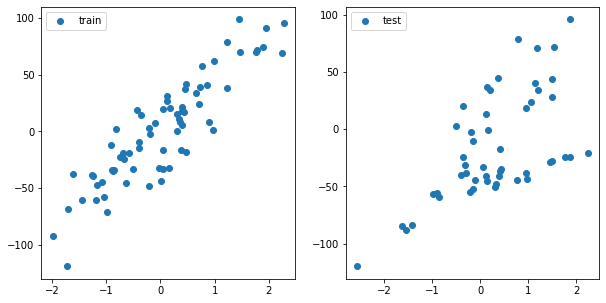

In [3]:
sample_size = 100
train_size = 0.7 #70%

X, y = make_regression(n_samples=sample_size, n_features=1, noise=20, random_state=0)
y = y.reshape(-1, 1)

np.random.seed(10)
random_idxs = np.random.permutation(np.arange(0, sample_size))[: int(np.ceil(sample_size * train_size))]
                                
X_train, y_train = X[random_idxs], y[random_idxs]
X_test, y_test = np.delete(X, random_idxs).reshape(-1, 1), np.delete(y, random_idxs).reshape(-1, 1)

### introduce bias in test data
bias = -50

X_r, y_r = make_regression(n_samples=20, n_features=1, noise=5, bias=bias, random_state=0)
X_test, y_test = np.r_[X_test, X_r], np.r_[y_test, y_r.reshape(-1, 1)]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(X_train, y_train, 'o', label='train')
ax[0].legend()
ax[1].plot(X_test, y_test, 'o', label='test')
ax[1].legend()
plt.show()

## Ridge with Normal Equation

### Loss Function

\begin{align}
    L(\theta) = ||y - X\theta||^2 + \lambda ||\theta||^2
\end{align}


In [4]:
def calculate_cost(X, y, theta, penalty):
    return np.linalg.norm(y - predict(X, theta)) + (penalty * np.square(np.linalg.norm(theta)))


### Algorithm 
\begin{align}
    \text{If } 
    X &= \text{independent variables}\\
    y &= \text{dependent variable}\\
    \lambda &= \text{penalty} \\
    \text{then }
    \theta &= \text{predictor} = (X^T X + \lambda I)^{-1}  X^T  y\\
    \\
\end{align}

In [5]:
def ridge_regression_normaleq(X, y, penalty=1.0):
    X = add_axis_for_bias(X)    
    m, n = X.shape
    theta = np.linalg.inv(X.T @ X + (penalty * np.eye(n))) @ X.T @ y
    return theta

In [6]:
def predict(X, theta):
    format_X = add_axis_for_bias(X)
    if format_X.shape[1] == theta.shape[0]:
        y_pred = format_X @ theta # (m,1) = (m,n) * (n,1)
        return y_pred
    elif format_X.shape[1] == theta.shape[1]:
        y_pred = format_X @ theta.T # (m,1) = (m,n) * (n,1)
        return y_pred
    else:
        raise ValueError("Shape is not proper.")

### Training

In [7]:
penalty_list = np.arange(0, 51, 10)
penalty_list

array([ 0, 10, 20, 30, 40, 50])

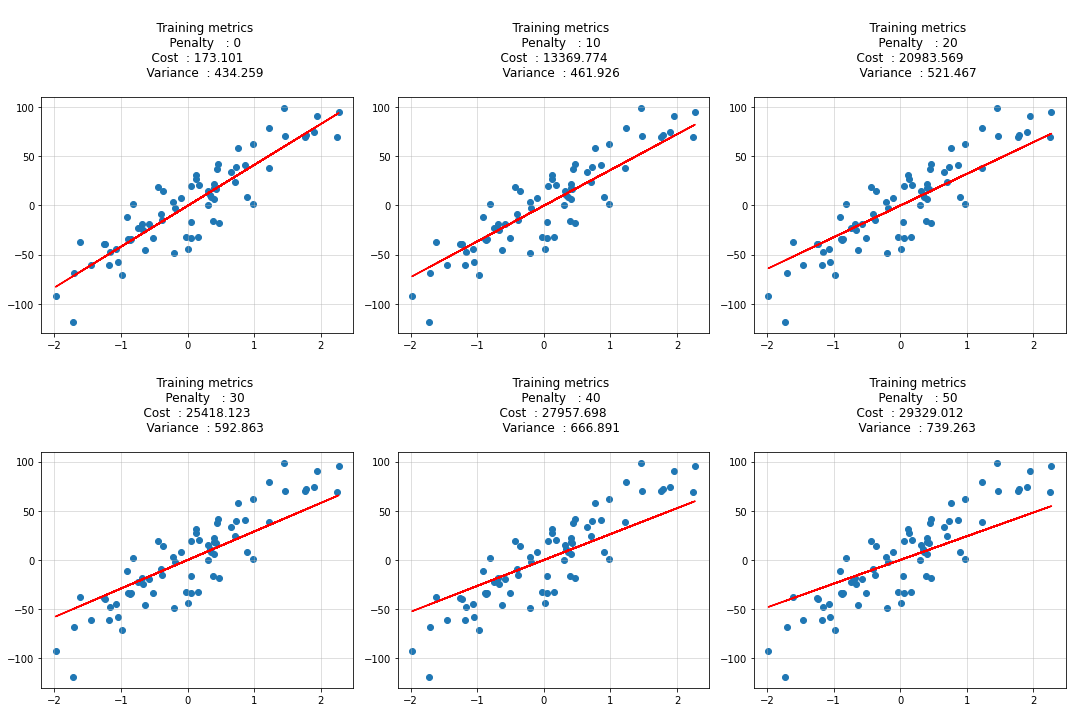

In [8]:
cost_list = []
variance_list = []

cols = 3
rows = np.int32(np.ceil(len(penalty_list)/ cols))

fig, ax = plt.subplots(rows, cols, figsize=(cols*5, rows*5))
ax = ax.ravel()


for idx, penalty in enumerate(penalty_list):
    theta = ridge_regression_normaleq(X_train, y_train, penalty=penalty)
    y_hat = predict(X_train, theta)
    cost = calculate_cost(X_train, y_train, theta, penalty)
    variance = (y_train - y_hat).var(ddof=1)
    
    cost_list.append(cost)
    variance_list.append(variance)
    
    ax[idx].scatter(X_train, y_train)
    ax[idx].plot(X_train, y_hat, c='r')
    
    ax[idx].set_title(f"""
    Training metrics
    Penalty   : {penalty}
    Cost  : {round(cost, 3)}    
    Variance  : {round(variance, 3)}
    """)
    ax[idx].grid(alpha=0.5)

plt.tight_layout()
plt.show()

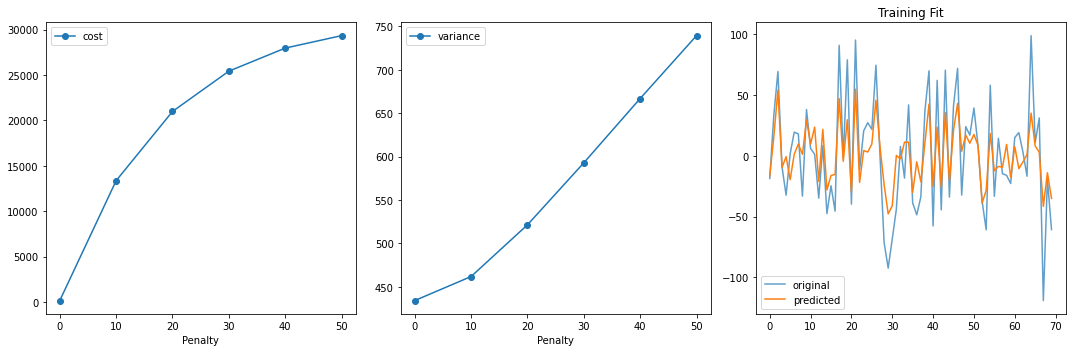

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(penalty_list, cost_list, 'o-', label='cost')
ax[0].set_xlabel("Penalty")
ax[0].legend()

ax[1].plot(penalty_list, variance_list, 'o-', label='variance')
ax[1].set_xlabel("Penalty")
ax[1].legend()

ax[2].plot(y_train, '-', label='original', alpha=0.7)
ax[2].plot(y_hat, '-', label='predicted')
ax[2].legend()
ax[2].set_title("Training Fit")

plt.tight_layout()
plt.show()


### Evaluation On Test Data

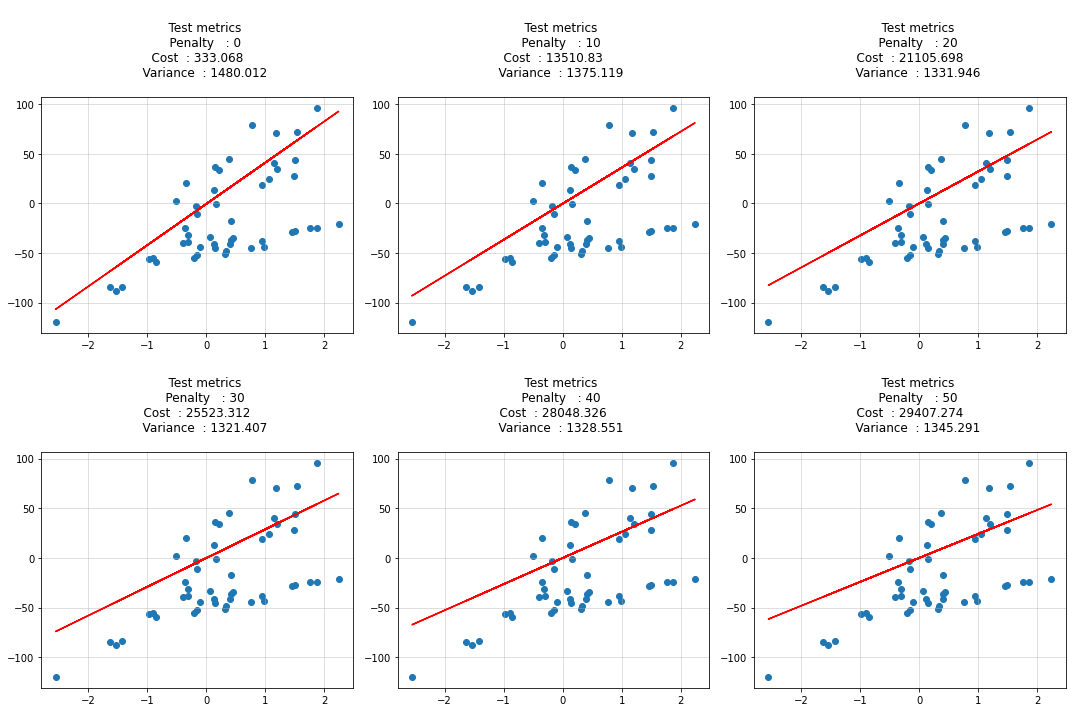

In [11]:
cost_list = []
pred_list = []
variance_list = []

cols = 3
rows = np.int32(np.ceil(len(penalty_list)/ cols))

fig, ax = plt.subplots(rows, cols, figsize=(cols*5, rows*5))
ax = ax.ravel()


for idx, penalty in enumerate(penalty_list):
    theta = ridge_regression_normaleq(X_train, y_train, penalty=penalty)
    y_hat = predict(X_test, theta)
    cost = calculate_cost(X_test, y_test, theta, penalty)
    variance = (y_test - y_hat).var(ddof=1)
    
    pred_list.append(y_hat[:, 0])
    cost_list.append(cost)
    variance_list.append(variance)
    
    ax[idx].scatter(X_test, y_test)
    ax[idx].plot(X_test, y_hat, c='r')
    
    ax[idx].set_title(f"""
    Test metrics
    Penalty   : {penalty}
    Cost  : {round(cost, 3)}    
    Variance  : {round(variance, 3)}
    """)
    ax[idx].grid(alpha=0.5)

plt.tight_layout()
plt.show()

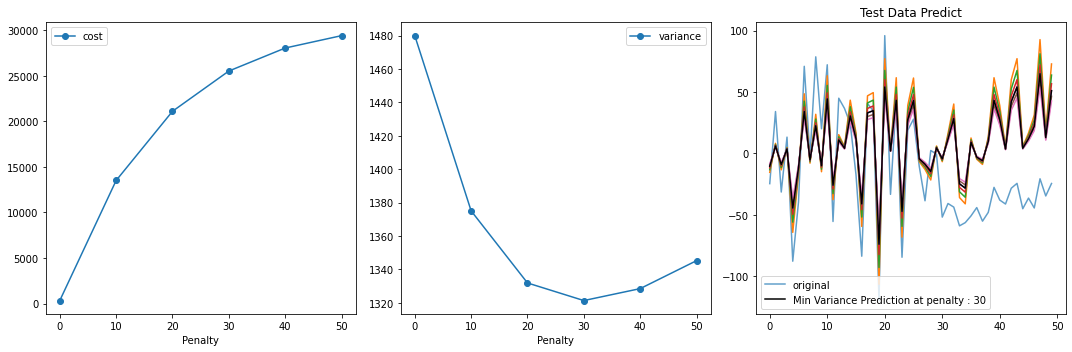

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(penalty_list, cost_list, 'o-', label='cost')
ax[0].set_xlabel("Penalty")
ax[0].legend()

ax[1].plot(penalty_list, variance_list, 'o-', label='variance')
ax[1].set_xlabel("Penalty")
ax[1].legend()

ax[2].plot(y_test, '-', label='original', alpha=0.7)
for i in pred_list:
    ax[2].plot(i, '-') 

min_var_idx = np.array(variance_list).argmin()
ax[2].plot(pred_list[min_var_idx], 'k-', label=f'Min Variance Prediction at penalty : {penalty_list[min_var_idx]}')    
ax[2].legend()
ax[2].set_title("Test Data Predict")

plt.tight_layout()
plt.show()

As I have introduced a bias in test data. that is not present in training data. but still based on my prior knowledge I introduced a penality in the learning algorithm. with increasing penalty variance in testing decreased and bias increased.

It might not be the best fit for training. but it stops from overfitting and out of time validation/real data/test data evaulation is improved.

## Ridge with BGD


Going to use the same data

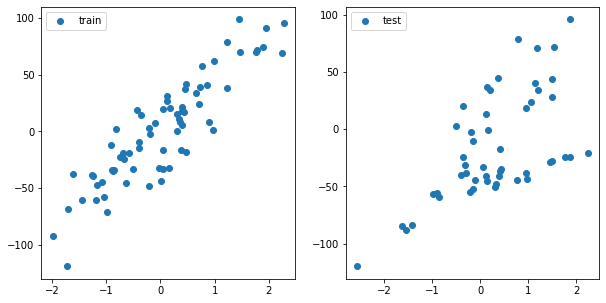

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(X_train, y_train, 'o', label='train')
ax[0].legend()
ax[1].plot(X_test, y_test, 'o', label='test')
ax[1].legend()
plt.show()

### Cost Function

\begin{align}
    J(\theta) &= \frac{1}{2m} \big[{\sum_{i=1}^{m}(h_{\theta}(x^{(i)}) - y^{(i)})^2 + \lambda \sum_{j=1}^{n}{\theta_j^2}} \big] \\
\end{align}

In [14]:
def calculate_cost(y_pred, y, penalty, theta):
    m = y.shape[0]
    return (np.square(y_pred - y).sum()/(2 * m)) + (penalty * np.square(theta).sum()/(2 * m))

### Derivative 
\begin{align}
   \text{derivative} = \frac{\partial{J(\theta)}}{\partial{\theta}} &=  \frac{1}{m}{\sum_{i=1}^{m}{(h_\theta(x^{(i)}) - y^{(i)})}}.{x_j^{(i)}} + \frac{\lambda}{m}{\theta_j}
\end{align}

In [15]:
def derivative(X, y, y_pred, penalty, theta):
    m, _ = X.shape
    return (np.sum( ( y_pred - y ) * X, axis = 0 ) / m)  + ((penalty * theta).sum() / m)

### Algorithm

\begin{align}
    \text{repeat until convergence \{}\\
    \theta_0 &:= \theta_0 - \alpha \frac{1}{m}{\sum_{i=1}^{m}{(h_\theta(x^{(i)}) - y^{(i)})}}.x_0^{(i)}\\
    \theta_j &:= \theta_j - \alpha \big{[} \frac{1}{m}{\sum_{i=1}^{m}{(h_\theta(x^{(i)}) - y^{(i)})}}.{x_j^{(i)}} + \frac{\lambda}{m}{\theta_j} \big{]}\\
    \text{\} j = 1,2,3,...,n}
\end{align} 

<!-- Ridge regression is very similar to least squares, except that the coefficients are estimated by minimizing a slightly different quantity. -->

In [16]:
def predict(X, theta):
    format_X = add_axis_for_bias(X)
        
    if format_X.shape[1] == theta.shape[0]:
        y_pred = format_X @ theta # (m,1) = (m,n) * (n,1)
        return y_pred
    elif format_X.shape[1] == theta.shape[1]:
        y_pred = format_X @ theta.T # (m,1) = (m,n) * (n,1)
        return y_pred
    else:
        raise ValueError("Shape is not proper.")

<!-- - here $\theta_0$ will not be effected by penalty but rest of the theta's $\theta_1 ... \theta_n$ will be effected by it. -->

In [17]:
def ridge_regression_bgd(X, y, verbose=True, theta_precision = 0.001, alpha = 0.01, iterations = 10000, penalty=1.0):
    
    X = add_axis_for_bias(X)
    m, n = X.shape

    theta_history = []
    cost_history = []

    # number of features+1 because of theta_0
    theta = np.random.rand(1,n) * theta_precision

    for iteration in range(iterations):
        
        theta_history.append(theta[0])

        # calculate y_pred 
        y_pred = X @ theta.T

        # simultaneous operation 
        gradient = derivative(X, y, y_pred, penalty, theta)
        new_gradient = np.c_[0, gradient[1:]][0] # removing for theta 0
        theta = theta - (alpha * new_gradient)
        

        if np.isnan(np.sum(theta)) or np.isinf(np.sum(theta)):
            print(f"breaking at iteration {iteration}. found inf or nan.")
            break
        
        # calculate cost to put in history
        cost = calculate_cost(predict(X, theta), y, penalty, theta)
        cost_history.append(cost)
        
    return theta, np.array(theta_history), np.array(cost_history)

### Training

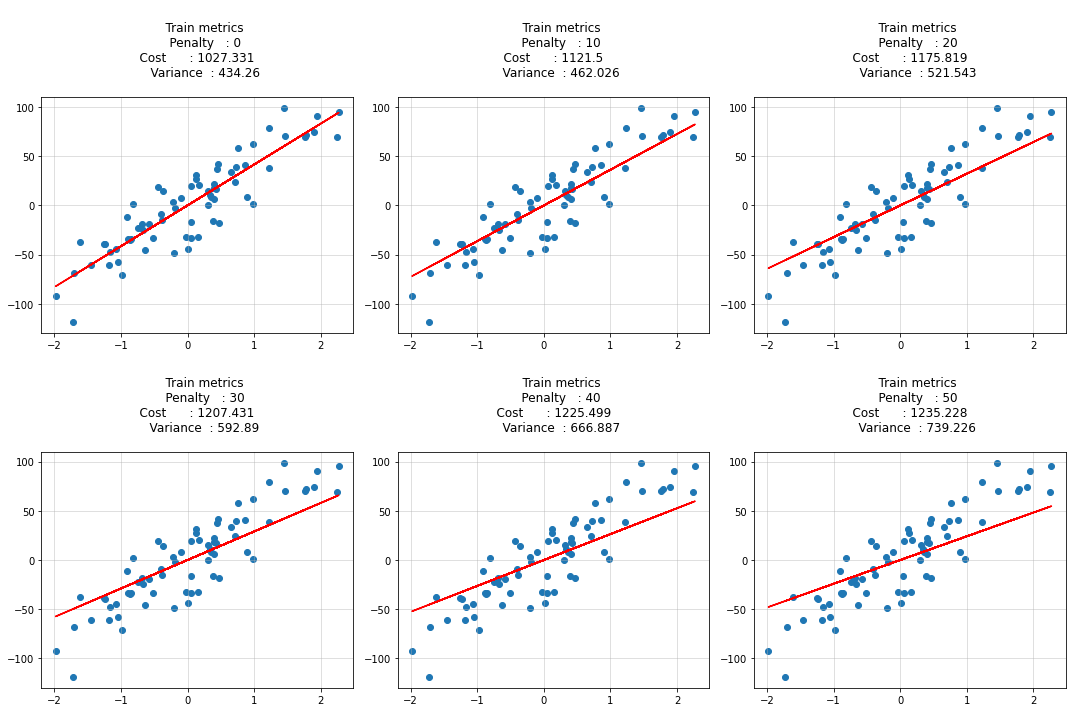

In [18]:
cost_list = []
bias_list = []
variance_list = []

cols = 3
rows = np.int32(np.ceil(len(penalty_list)/ cols))

fig, ax = plt.subplots(rows, cols, figsize=(cols*5, rows*5))
ax = ax.ravel()


for idx, penalty in enumerate(penalty_list):
    theta, _, _ = theta, theta_history, cost_history = ridge_regression_bgd(
        X_train, y_train, verbose=True, theta_precision = 0.001, 
        alpha = 0.03, iterations = 300, 
        penalty = penalty
    )
    y_hat = predict(X_train, theta)
    cost = calculate_cost(X_train, y_train, penalty, theta)
    variance = (y_train - y_hat).var(ddof=1)
    
    bias_list.append(theta[0][0])
    cost_list.append(cost)
    variance_list.append(variance)
    
    ax[idx].scatter(X_train, y_train)
    ax[idx].plot(X_train, y_hat, c='r')
    
    ax[idx].set_title(f"""
    Train metrics
    Penalty   : {penalty}
    Cost      : {round(cost, 3)}    
    Variance  : {round(variance, 3)}
    """)
    ax[idx].grid(alpha=0.5)

plt.tight_layout()
plt.show()

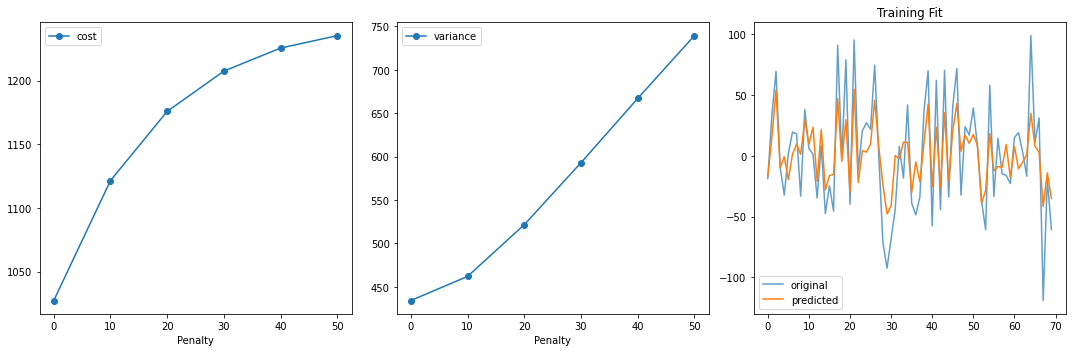

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(penalty_list, cost_list, 'o-', label='cost')
ax[0].set_xlabel("Penalty")
ax[0].legend()

ax[1].plot(penalty_list, variance_list, 'o-', label='variance')
ax[1].set_xlabel("Penalty")
ax[1].legend()

ax[2].plot(y_train, '-', label='original', alpha=0.7)
ax[2].plot(y_hat, '-', label='predicted')
ax[2].legend()
ax[2].set_title("Training Fit")

plt.tight_layout()
plt.show()

### Testing

In [21]:
penalty_list = np.arange(0, 51, 10)
penalty_list

array([ 0, 10, 20, 30, 40, 50])

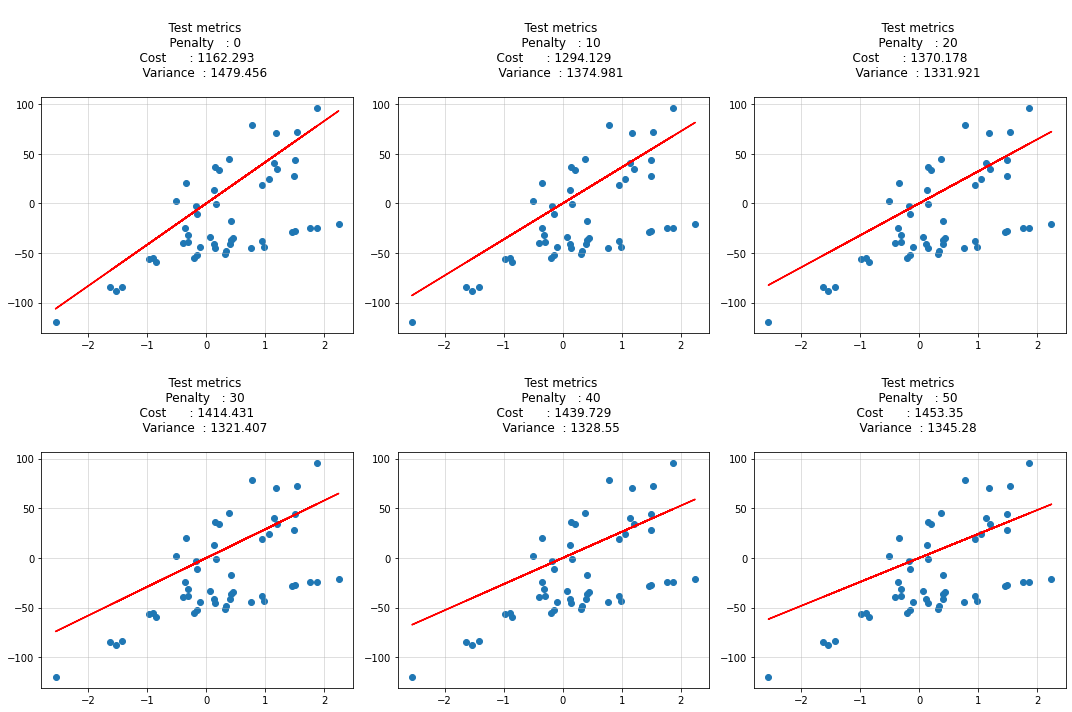

In [22]:
cost_list = []
pred_list = []
variance_list = []

cols = 3
rows = np.int32(np.ceil(len(penalty_list)/ cols))

fig, ax = plt.subplots(rows, cols, figsize=(cols*5, rows*5))
ax = ax.ravel()


for idx, penalty in enumerate(penalty_list):
    theta, _, _ = theta, theta_history, cost_history = ridge_regression_bgd(
        X_train, y_train, verbose=True, theta_precision = 0.001, 
        alpha = 0.03, iterations = 300, 
        penalty = penalty
    )
    y_hat = predict(X_test, theta)
    cost = calculate_cost(X_test, y_test, penalty, theta)
    variance = (y_test - y_hat).var(ddof=1)
    
    pred_list.append(y_hat[:, 0])
    cost_list.append(cost)
    variance_list.append(variance)
    
    ax[idx].scatter(X_test, y_test)
    ax[idx].plot(X_test, y_hat, c='r')
    
    ax[idx].set_title(f"""
    Test metrics
    Penalty   : {penalty}
    Cost      : {round(cost, 3)}    
    Variance  : {round(variance, 3)}
    """)
    ax[idx].grid(alpha=0.5)

plt.tight_layout()
plt.show()

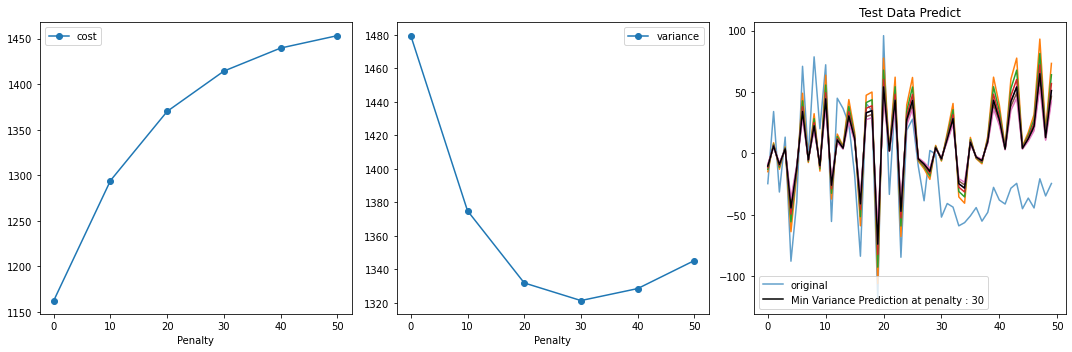

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(penalty_list, cost_list, 'o-', label='cost')
ax[0].set_xlabel("Penalty")
ax[0].legend()

ax[1].plot(penalty_list, variance_list, 'o-', label='variance')
ax[1].set_xlabel("Penalty")
ax[1].legend()

ax[2].plot(y_test, '-', label='original', alpha=0.7)
for i in pred_list:
    ax[2].plot(i, '-') 

min_var_idx = np.array(variance_list).argmin()
ax[2].plot(pred_list[min_var_idx], 'k-', label=f'Min Variance Prediction at penalty : {penalty_list[min_var_idx]}')    
ax[2].legend()
ax[2].set_title("Test Data Predict")

plt.tight_layout()
plt.show()

### Training Animation

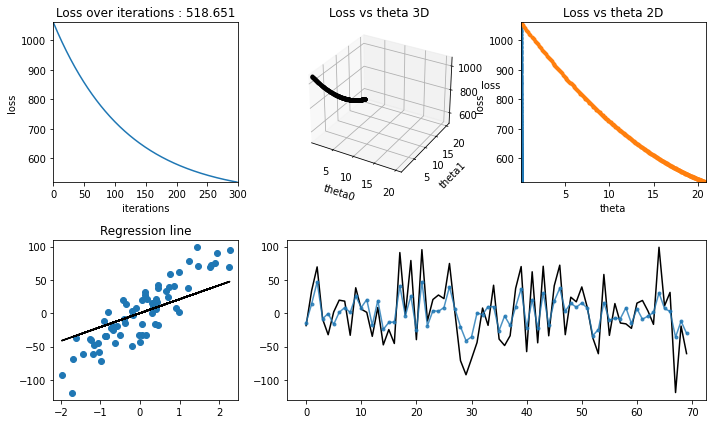

In [24]:
iterations = 300
learning_rate = 0.003
penalty = 30.0

theta, theta_history, cost_history = ridge_regression_bgd(
    X_train, y_train, verbose=True, theta_precision = 0.1,
    alpha = learning_rate, iterations = iterations,
    penalty = penalty
)

regression_animation(X_train, y_train, cost_history, theta_history, iterations, interval=10)
# regression_plot(X_train, y_train, cost_history, theta_history, iterations);

<!-- ## Ridge with SGD

def ridge_regression_sgd(X, y, verbose=True, theta_precision = 0.001, batch_size=30, 
                         alpha = 0.01, iterations = 10000, penalty=1.0):
    X = add_axis_for_bias(X)
    
    # number of features+1 because of theta_0
    n = X.shape[1]
    m = y.shape[0]

    theta_history = []
    cost_history = []

    theta = np.random.rand(1,n) * theta_precision
#     if verbose: print("random initial θ value :",theta)
    
    for iteration in range(iterations):
        
        theta_history.append(theta[0])
        
        # creating indices for batches
        indices = np.random.randint(0, m, size=batch_size)

        # creating batch for this iteration
        X_batch = X[indices,:]
        y_batch = y[indices,:]

        # calculate y_pred 
        y_pred = predict(X_batch, theta)

        # simultaneous operation 
        gradient = derivative(X_batch, y_batch, y_pred, penalty, theta)
        theta = theta - (alpha *  gradient)
        
        if np.isnan(np.sum(theta)) or np.isinf(np.sum(theta)):
            print(f"breaking at iteration {iteration}. found inf or nan.")
            break

        # calculate cost to put in history
        cost = calculate_cost(predict(X_batch, theta), y_batch, penalty, theta)
        cost_history.append(cost)

    return theta, np.array(theta_history), np.array(cost_history)

iterations = 300
learning_rate = 0.01
penalty = 50
theta, theta_history, cost_history = ridge_regression_sgd(X, y, verbose=True, theta_precision = 0.001, 
                                                           alpha = learning_rate,iterations = iterations, 
                                                           penalty=penalty)

# regression_animation(X, y, cost_history, theta_history, iterations, interval=10);
regression_plot(X_train, y_train, test_cost_history, theta_history, iterations); -->